<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/labs/cs473_lab_week_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><p><b>After clicking the "Open in Colab" link, copy the notebook to your own Google Drive before getting started, or it will not save your work</b></p>

# BYU CS 473 Lab Week 9

## Introduction:

You will turn in an iPython notebook that performs Gaussian process regression on a simple dataset. You will explore multiple kernels and vary their parameter settings.

When you are done, you should produce visualizations like the following (for noiseless observations):

![noiseless figure](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_9_image1.png)

and like this (for noisy observations):

![noisy figure](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_9_image2.png)


---
## Grading standards   

Your notebook will be graded on the following:

* 20% Correct implementation of three kernels
* 30% Correct implementation of noiseless GPR
* 30% Correct implementation of noisy GPR
* 20% Six tidy and legible plots, with appropriate ranges

---
## Description

The data that we will use for this lab is simple:

```python
data_xvals = numpy.atleast_2d( [ 1.0, 3.0, 5.0, 6.0, 7.0, 8.0 ] )
data_yvals = numpy.sin( data_xvals )
```
You must perform Gaussian process regression on this dataset, and produce visualizations for both noiseless and noisy observations.

The key equations are given in 17.28 - 17.30 (for the noiseless case) and 17.34-17.36 (for the noisy case).

Your notebook should produce one visualization for each of the following kernel types:

* The linear kernel
* The Gaussian (or RBF) kernel (Eqn. 17.3)
* The polynomial kernel (in the text right after Eqn. 17.20)

Therefore, your notebook should produce six different visualizations: two for each kernel type.

For the noisy observation case, use \sigma_n^2=0.1.

For the polynomial kernel use a degree of 3.

For the Gaussian / RBF kernel, set all parameters to 1.0

The mean function for this lab should always return 0.

You should also answer the following questions:

* What happens when the bandwidth parameter \sigma_n of the Gaussian kernel gets small? Gets large?
* What happens when the degree M of the polynomial kernel gets small? Gets large?

Your visualizations should be done on the range [-2 10] of the x-axis.

For the errorbars, you can just plot the mean +/- the variance. This isn't really a statistically meaningful quantity, but it makes the plots look nice. :)

*Hint: a Gaussian process only allows you to make a prediction for a single query point. So how do you generate the smoothly varying lines in the example images?*


---
## Hints

The following functions may be useful to you:

In [2]:
# numpy.arange()

# plt.gca().fill_between
# plt.scatter

# numpy.linalg.pinv

# numpy.eye

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data_xvals = np.atleast_2d( [ 1.0, 3.0, 5.0, 6.0, 7.0, 8.0 ] ).T
data_yvals = np.sin( data_xvals )

print(f"Shape of X data: {data_xvals.shape}")
print(f"Shape of y data: {data_yvals.shape}")

Shape of X data: (6, 1)
Shape of y data: (6, 1)


linear kernel k(x, x') = x^T x'<br>
kernel k(x, x') = sigma_f^2 * exp(-0.5 * ||x - x'||^2 / l^2)<br>
k(x, x') = (x^T x' + c)^M

In [5]:
def linear_kernel(X1, X2):
    return X1 @ X2.T

In [13]:
def rbf_kernel(X1, X2, sigma_f=1.0, l=1.0):
    X1_sq = np.sum(X1**2, axis=1).reshape(-1, 1)
    X2_sq = np.sum(X2**2, axis=1).reshape(1, -1)
    sqdist = X1_sq + X2_sq - 2 * (X1 @ X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [14]:
def polynomial_kernel(X1, X2, c=1.0, M=3):
    return (X1 @ X2.T + c)**M

In [15]:
def gpr_predict(X_train, y_train, X_query, kernel_func, sigma_n_sq=0.0):

    N = X_train.shape[0]

    K = kernel_func(X_train, X_train)  # Calculate K_y = K + sigma_n^2 * I
    K_y = K + sigma_n_sq * np.eye(N)

    K_y_inv = np.linalg.pinv(K_y) # inverse it

    k_star = kernel_func(X_train, X_query)
    k_star_star = np.diag(kernel_func(X_query, X_query))

    mu_star = k_star.T.dot(K_y_inv.dot(y_train)) #posterior mean

    var_term = np.sum((k_star.T.dot(K_y_inv)) * k_star.T, axis=1) # posterior variance
    var_star = k_star_star - var_term

    return mu_star.flatten(), var_star.flatten()

In [31]:
def plot_gpr(mu, var, X_query, X_train, y_train, title):
    X_query_flat = X_query.flatten()
    X_train_flat = X_train.flatten()
    y_train_flat = y_train.flatten()

    std_dev = np.sqrt(np.maximum(var, 0))

    plt.figure(figsize=(10, 6))
    plt.plot(X_query_flat, mu, 'b-', lw=2, label='Mean')
    plt.gca().fill_between(X_query_flat, mu - std_dev, mu + std_dev,
                             color='mediumpurple', alpha=0.3, label='Variance')
    plt.scatter(X_train_flat, y_train_flat, c='black', s=100, lw=1, label='Training Data')
    plt.title(title, fontsize=16)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('f(x)', fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True, linestyle=':')
    plt.xlim([-2, 10])
    plt.show()

In [33]:
X_query = np.linspace(-2, 10, 200).reshape(-1, 1)

k_linear = lambda X1, X2: linear_kernel(X1, X2)
k_rbf = lambda X1, X2: rbf_kernel(X1, X2, sigma_f=1.0, l=1.0)
k_poly = lambda X1, X2: polynomial_kernel(X1, X2, c=1.0, M=3)

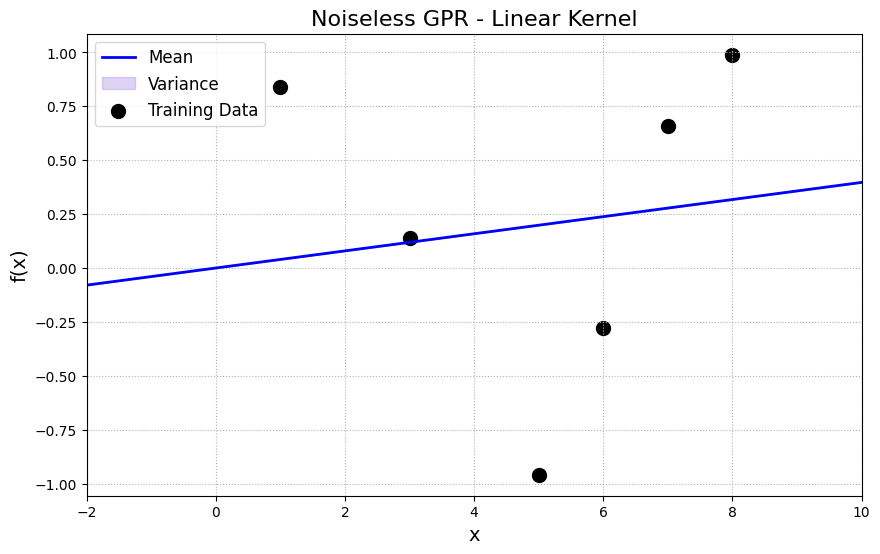

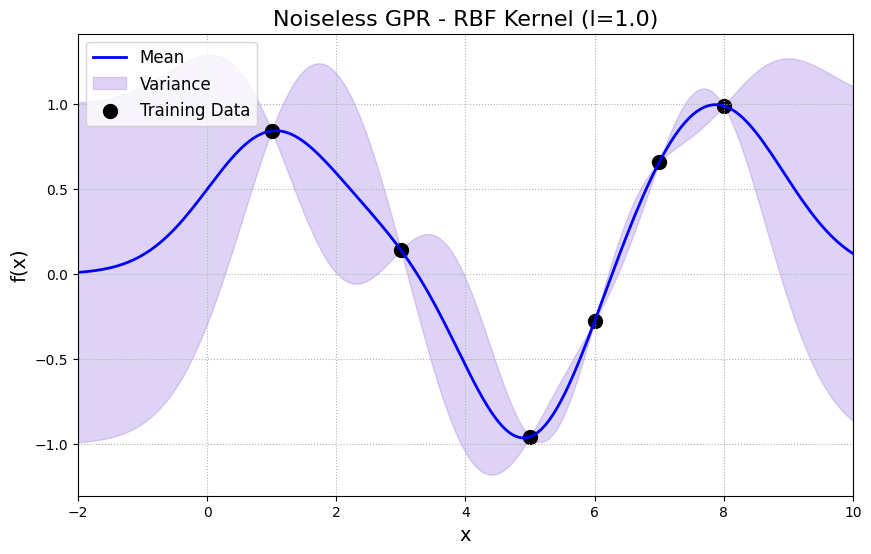

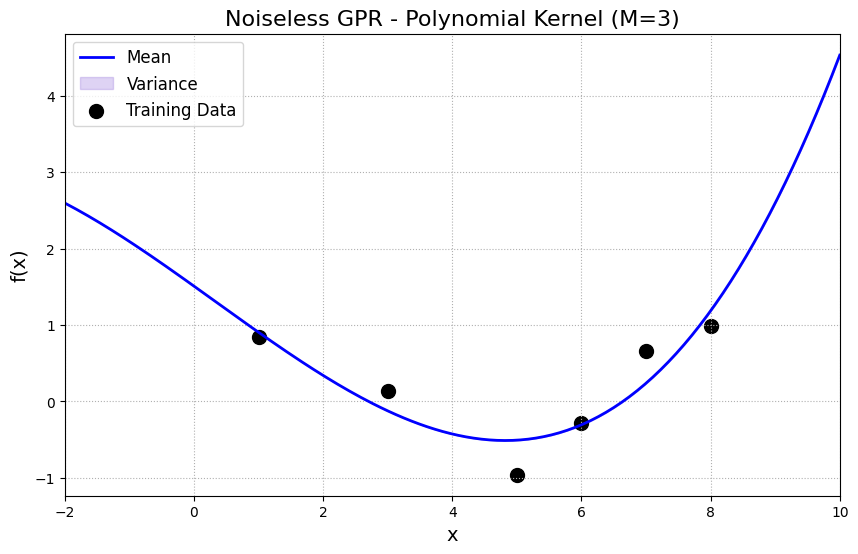

In [35]:
# Noiseless GPR
sigma_n_sq_noiseless = 0.0

mu_lin, var_lin = gpr_predict(data_xvals, data_yvals, X_query, k_linear, sigma_n_sq_noiseless)
plot_gpr(mu_lin, var_lin, X_query, data_xvals, data_yvals, 'Noiseless GPR - Linear Kernel')

mu_rbf, var_rbf = gpr_predict(data_xvals, data_yvals, X_query, k_rbf, sigma_n_sq_noiseless)
plot_gpr(mu_rbf, var_rbf, X_query, data_xvals, data_yvals, 'Noiseless GPR - RBF Kernel (l=1.0)')

mu_poly, var_poly = gpr_predict(data_xvals, data_yvals, X_query, k_poly, sigma_n_sq_noiseless)
plot_gpr(mu_poly, var_poly, X_query, data_xvals, data_yvals, 'Noiseless GPR - Polynomial Kernel (M=3)')

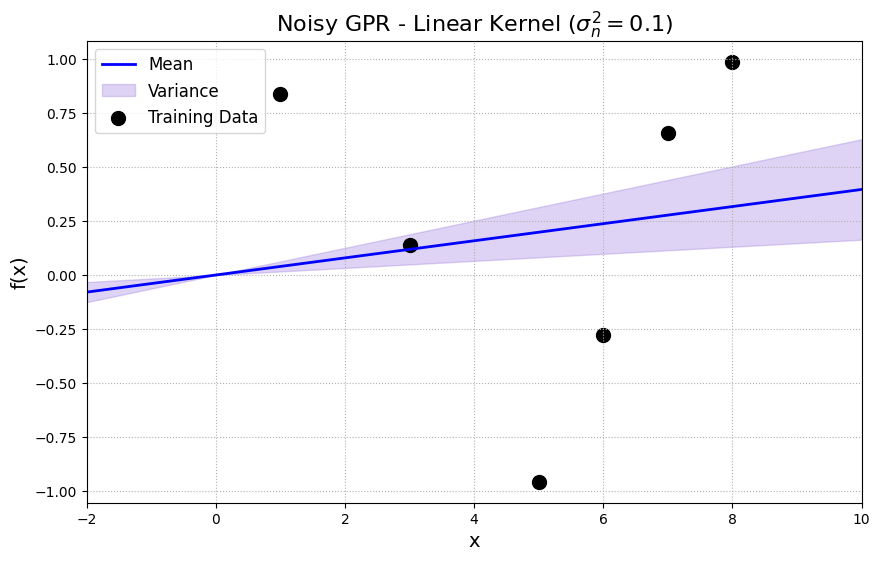

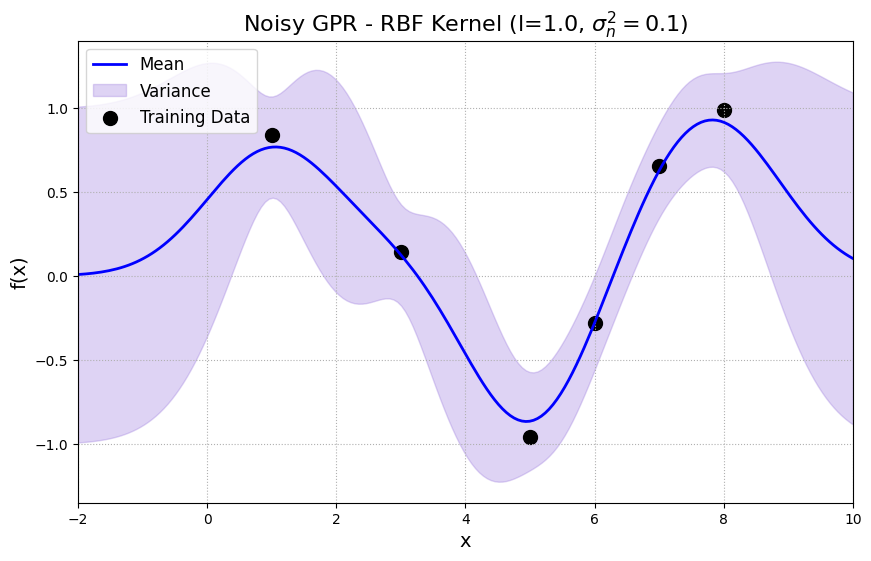

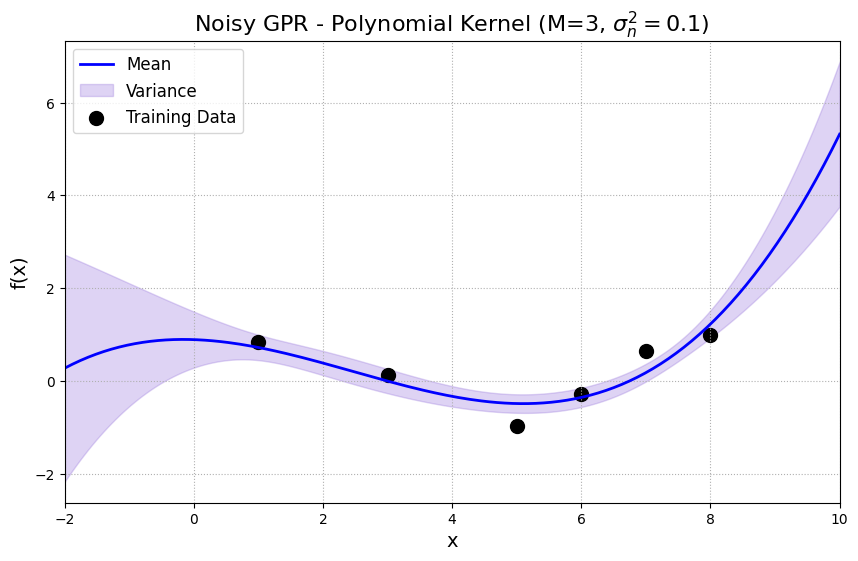

In [36]:
# Noisy GPR
sigma_n_sq_noisy = 0.1

mu_lin_n, var_lin_n = gpr_predict(data_xvals, data_yvals, X_query, k_linear, sigma_n_sq_noisy)
plot_gpr(mu_lin_n, var_lin_n, X_query, data_xvals, data_yvals, f'Noisy GPR - Linear Kernel ($\\sigma_n^2={sigma_n_sq_noisy}$)')

mu_rbf_n, var_rbf_n = gpr_predict(data_xvals, data_yvals, X_query, k_rbf, sigma_n_sq_noisy)
plot_gpr(mu_rbf_n, var_rbf_n, X_query, data_xvals, data_yvals, f'Noisy GPR - RBF Kernel (l=1.0, $\\sigma_n^2={sigma_n_sq_noisy}$)')

mu_poly_n, var_poly_n = gpr_predict(data_xvals, data_yvals, X_query, k_poly, sigma_n_sq_noisy)
plot_gpr(mu_poly_n, var_poly_n, X_query, data_xvals, data_yvals, f'Noisy GPR - Polynomial Kernel (M=3, $\\sigma_n^2={sigma_n_sq_noisy}$)')

#### 1. What happens when the bandwidth parameter of the Gaussian kernel gets small? Gets large?

* **Gets Small (e.g., l -> 0):**
When the lengthscale(l) is small, the kernel function becomes very spiky. if x moves away from x' then drops to zero this is due to correlation when they close to each other.This leads to overfitting.

* **Gets Large (e.g., l -> infinity):**
When the lengthscale(l) is large, the kernel function becomes very wide or smooth. this is due to high correlation regardless of their distance. This leads to underfitting.


#### 2. What happens when the degree M of the polynomial kernel gets small?  Gets large?

* **Gets Small (e.t., M=1):**
This is a linear model. The GPR model will only be able to fit a straight line to the data. This is underfitting and its poor approximation for our sin data.

* **Gets Large (e.g., M=10):**
the kernel is extremely flexble and becomes a high-degree polynomial.  
Which allows to  fit the training data and it is certainly
overfit.